In [10]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision

from torchinfo import summary
from torch import nn
from torchvision import transforms
from torch.utils.data import (Dataset, DataLoader)

from PIL import Image
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from scikitplot.metrics import plot_roc

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, top_k_accuracy_score, f1_score, 
    matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
)

In [11]:
class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_DEVICES = torch.cuda.device_count()
    NUM_WORKERS = os.cpu_count()
    NUM_CLASSES = 45
    EPOCHS = 10
    BATCH_SIZE = (
        32 if torch.cuda.device_count() < 2 
        else (32 * torch.cuda.device_count())
    )
    LR = 0.001
    APPLY_SHUFFLE = True
    SEED = 768
    HEIGHT = 256
    WIDTH = 256
    CHANNELS = 3
    IMAGE_SIZE = (256, 256, 3)

In [12]:
# Define paths
PROJECT_ROOT = os.getcwd()
# DATASET_PATH = "./mammals"
DATASET_PATH = os.path.join(PROJECT_ROOT, "mammals")

TRAIN_PATH = DATASET_PATH


In [13]:
%%time
image_paths = glob.glob(f"{TRAIN_PATH}/**/*.jpg", recursive=True)

CPU times: user 23.2 ms, sys: 18.9 ms, total: 42.1 ms
Wall time: 40.3 ms


In [14]:
def extract_labels(image_paths):
    return [os.path.basename(os.path.dirname(path)) for path in image_paths]

dataset_df = pd.DataFrame({
    'image_path': image_paths,
    'label': extract_labels(image_paths)
})

print(dataset_df.head())  # View first 5 samples


                                          image_path       label
0  /Users/upekhansaja/Documents/Projects/Python/m...  rhinoceros
1  /Users/upekhansaja/Documents/Projects/Python/m...  rhinoceros
2  /Users/upekhansaja/Documents/Projects/Python/m...  rhinoceros
3  /Users/upekhansaja/Documents/Projects/Python/m...  rhinoceros
4  /Users/upekhansaja/Documents/Projects/Python/m...  rhinoceros


In [15]:
train_df, test_val_df = train_test_split(dataset_df, test_size=0.30, stratify=dataset_df['label'], random_state=42)
val_df, test_df = train_test_split(test_val_df, test_size=0.65, stratify=test_val_df['label'], random_state=42)

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")


Train: 9625, Validation: 1444, Test: 2682


In [16]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [17]:
class MammalsDataset(Dataset):
    def __init__(self, df, transform=None):
        self.paths = df['image_path'].to_list()
        self.labels = df['label'].to_list()
        self.transform = transform
        self.classes = sorted(df['label'].unique())
        self.label_encoder = LabelEncoder().fit(self.classes)
        self.label_indices = self.label_encoder.transform(self.labels)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = Image.open(self.paths[idx]).convert('RGB')
        label = self.label_indices[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [18]:
train_dataset = MammalsDataset(train_df, transform=train_transforms)
val_dataset = MammalsDataset(val_df, transform=test_transforms)
test_dataset = MammalsDataset(test_df, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [19]:
def build_model():
    model = torchvision.models.efficientnet_v2_l(weights="DEFAULT")
    
    for param in model.features.parameters():
        param.requires_grad = False  # Freeze feature extractor
    
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1280, len(train_dataset.classes))
    )

    return model.to("cuda" if torch.cuda.is_available() else "cpu")


In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(build_model().parameters(), lr=0.001)


In [ ]:
def train(model, train_loader, val_loader, epochs=10):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
        
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {correct / len(train_loader.dataset):.4f}")

train(build_model(), train_loader, val_loader, epochs=5)

torch.save(model.state_dict(), "model.pth")
print("Model saved successfully!")


In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds)
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def calculate_accuracy(model, test_loader):
    model.eval()
    correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(dim=1) == labels).sum().item()

    print(f"Test Accuracy: {correct / len(test_loader.dataset):.4f}")

# Call function with the correct device
calculate_accuracy(build_model(), test_loader)

In [ ]:
# Predict which animal(s) are in the images contain animals

In [23]:
from torchvision import transforms
from PIL import Image
import torch

# Ensure the same label encoding is used
label_encoder = LabelEncoder()
label_encoder.fit(train_dataset.classes)

def predict_image(model, image_path, device="cpu"):
    """Loads an image, preprocesses it, and predicts its label."""
    
    # Define image transformations (same as test preprocessing)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move image to the same device as model
    image = image.to(device)
    model.to(device)
    
    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        output = model(image)  # Get predictions
        predicted_class_idx = output.argmax(dim=1).item()  # Get highest score
        predicted_class = label_encoder.inverse_transform([predicted_class_idx])[0]  # Convert to label
    
    return predicted_class


In [24]:
image_path = "/Users/upekhansaja/Documents/Projects/Python/Test/adobestock-573332061.jpeg"  # Change this to a real image
model = build_model()  # Load model
model.load_state_dict(torch.load("model.pth"))  # Load trained model weights

predicted_label = predict_image(model, image_path, device)
print(f"Predicted Animal: {predicted_label}")


Predicted Animal: zebra


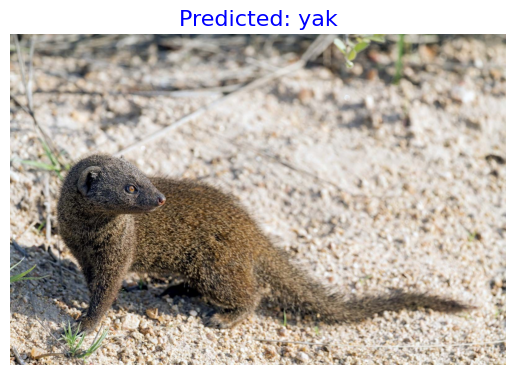

In [48]:
import matplotlib.pyplot as plt

def show_prediction(image_path, model):
    predicted_label = predict_image(model, image_path, device)

    # Load and show the image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label}", fontsize=16, color="blue")
    plt.show()

image_path = "/Users/upekhansaja/Downloads/mongoose.jpeg"  # Change this
show_prediction(image_path, model)


In [27]:
torch.save(model.state_dict(), "model.pth")


Actual Label: weasel


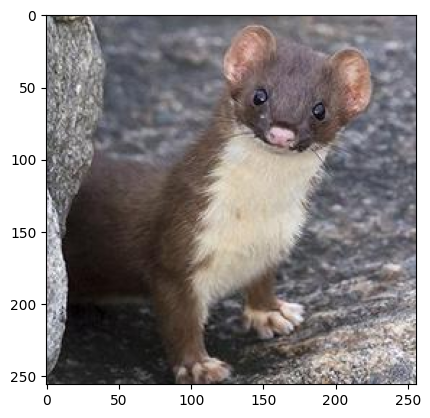

In [49]:
class_names = train_loader.dataset.classes  # Get class names
for images, labels in train_loader:
    label_name = class_names[labels[0]]  # Convert number to name
    print(f"Actual Label: {label_name}")  
    plt.imshow(images[0].permute(1, 2, 0))
    plt.show()
    break


Predicted: yak, Actual: mongoose


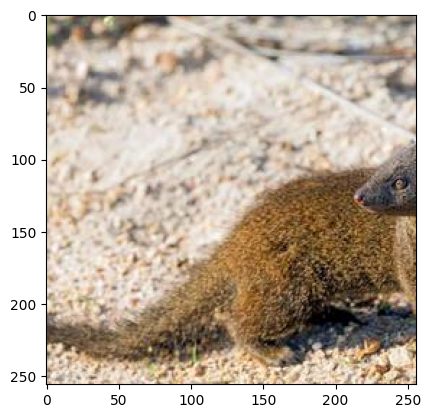

In [51]:
for images, labels in test_loader:
    outputs = model(images)
    _, preds = torch.max(outputs, 1)  # Get the predicted class index
    print(f"Predicted: {class_names[preds[0]]}, Actual: {class_names[labels[0]]}")
    plt.imshow(images[0].permute(1, 2, 0))
    plt.show()
    break


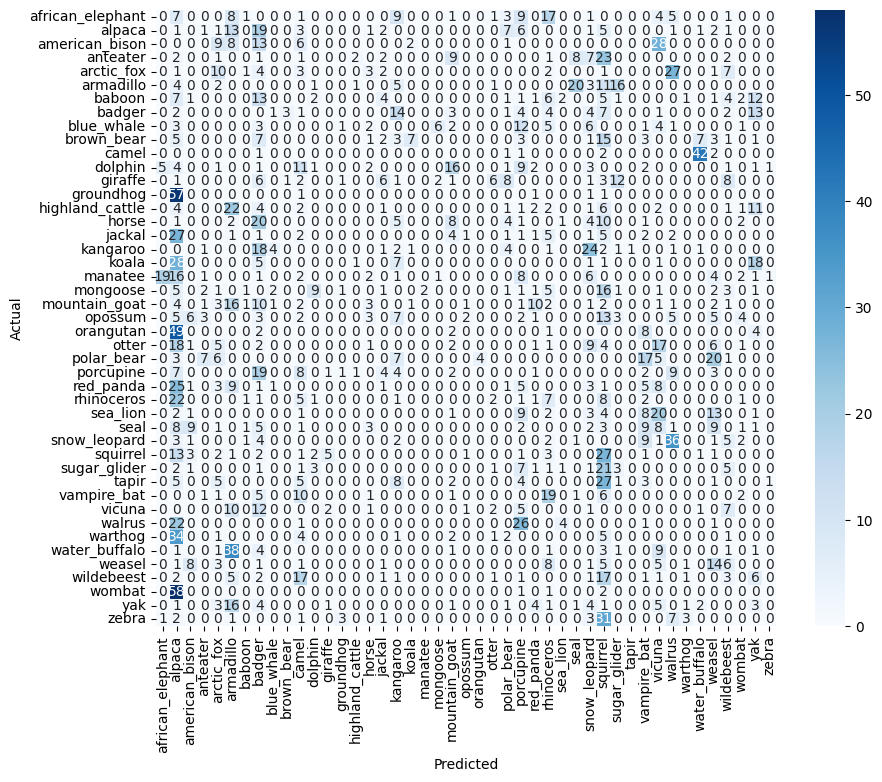

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []
for images, labels in test_loader:
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
